## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [0]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [0]:
len(fmnist_dataset_test)

10000

In [0]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [0]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
         LeakyReLU-3                  [-1, 784]               0
           Dropout-4                  [-1, 784]               0
            Linear-5                   [-1, 10]           7,850
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.38
Estimated Total Size (MB): 2.40
----------------------------------------------------------------


Your experiments come here:

In [0]:
# train function
def train(isLrScheduller=False):
    running_loss = 0.0
    train_acc = 0.0
    len_all = 0.0
    loss_train = 0.0
  
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss_val = loss_func(outputs, targets)
        loss_val.backward()
        opt.step()
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        # accumulate metrics on the test
        train_acc += accuracy_add 
        len_all += len(targets)
        loss_train += len(targets) * loss_val.item()
    if isLrScheduller:    
      lr_scheduler.step(running_loss)
    return train_acc / len_all, loss_train / len_all

In [0]:
# function for loss and accuracy drawing
def loss_accuracy_plot(accuracy_history_test, accuracy_history_train, loss_history_test, loss_history_train):
  fig, ax = plt.subplots(figsize=[15, 5])
  plt.subplot(1, 2, 1)
  plt.plot(accuracy_history_test, label='test accuracy')
  plt.plot(accuracy_history_train, label='train accuracy')
  plt.legend(loc='best')
  plt.title('Test and train accuracyes')
  plt.grid('True')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(loss_history_test, label='test loss')
  plt.plot(loss_history_train, label='train loss')
  plt.legend(loc='best')
  plt.title('Train and test losses')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [0]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1.0e-3) # YOUR CODE HERE
loss_func = torch.nn.CrossEntropyLoss() # YOUR CODE HERE

# reduction in the larnings if we go out on the plateau
# the  decision will be made on a validation sample
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, verbose=True, patience=7, factor=0.2)


In [0]:
accuracy_history_test = []
accuracy_history_train = []

loss_history_test = []
loss_history_train = []
num_epoch = 70
for epoch in range(num_epoch):
  train_acc, loss_train = train(isLrScheduller=True)
  loss_test_accumulated = 0.0
  accuracy_accumulated = 0.0
  for _, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    test_preds = model(inputs)
    loss_test = loss_func(test_preds, targets).item()
    accuracy_accumulated += float((test_preds.argmax(dim=1) == targets).float().mean().data.cpu())
    loss_test_accumulated += float(loss_test)

  len_test_loader = len(test_loader)
  accuracy = accuracy_accumulated / len_test_loader
  accuracy_history_test.append(accuracy)
  accuracy_history_train.append(train_acc)
  print('Epoch:', epoch, '    acc_train:', np.round(float(train_acc), 4), '    acc_test:', np.round(accuracy, 4))
  loss_history_test.append(loss_test_accumulated / len_test_loader)
  loss_history_train.append(float(loss_train))


Epoch: 0     acc_train: 0.7995     acc_test: 0.8259
Epoch: 1     acc_train: 0.8479     acc_test: 0.8372
Epoch: 2     acc_train: 0.8582     acc_test: 0.8499
Epoch: 3     acc_train: 0.8648     acc_test: 0.8548
Epoch: 4     acc_train: 0.8709     acc_test: 0.8597
Epoch: 5     acc_train: 0.8752     acc_test: 0.8648
Epoch: 6     acc_train: 0.879     acc_test: 0.8644
Epoch: 7     acc_train: 0.8797     acc_test: 0.8629
Epoch     9: reducing learning rate of group 0 to 2.0000e-04.
Epoch: 8     acc_train: 0.8841     acc_test: 0.868
Epoch: 9     acc_train: 0.8975     acc_test: 0.8812
Epoch: 10     acc_train: 0.901     acc_test: 0.8789
Epoch: 11     acc_train: 0.9029     acc_test: 0.8805
Epoch: 12     acc_train: 0.9039     acc_test: 0.8799
Epoch: 13     acc_train: 0.9053     acc_test: 0.8798
Epoch: 14     acc_train: 0.9068     acc_test: 0.8862
Epoch: 15     acc_train: 0.9067     acc_test: 0.8836
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
Epoch: 16     acc_train: 0.9088     acc_t

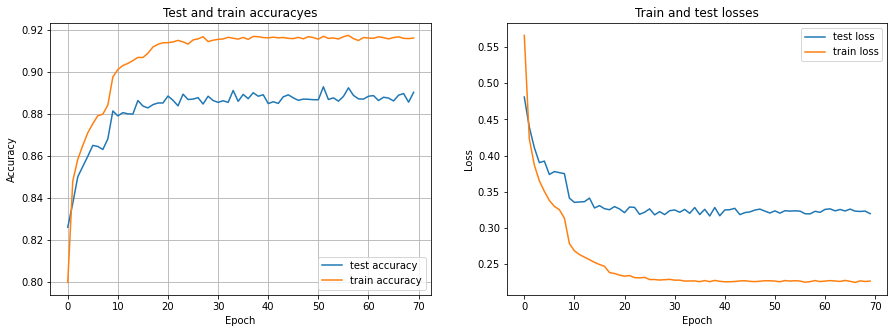

In [0]:
loss_accuracy_plot(accuracy_history_test, accuracy_history_train, loss_history_test, loss_history_train)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [0]:
from torch.functional import F
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, layer_num=2):
        super(self.__class__, self).__init__()
        self.layer_input = nn.Linear(input_shape,256)
        self.layer_hidden_one = nn.Linear(256,128)
        self.layer_hidden_two = nn.Linear(128,64)
        self.layer_hidden_three = nn.Linear(64, input_shape)
        self.layer_output = nn.Linear(input_shape, num_classes)
        
    def forward(self, out):       
        # Flattened the input to make sure it fits the layer input
        out = out.view(out.shape[0],-1)
        out = F.relu(self.layer_input(out))
        out = F.relu(self.layer_hidden_one(out))
        out = F.relu(self.layer_hidden_two(out))
        out = F.relu(self.layer_hidden_three(out))
        out = F.log_softmax(self.layer_output(out),dim=1)
        return out
        


In [0]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                  [-1, 784]          50,960
            Linear-5                   [-1, 10]           7,850
Total params: 300,922
Trainable params: 300,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.15
Estimated Total Size (MB): 1.16
----------------------------------------------------------------


In [0]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1.0e-3) 
loss_func = nn.NLLLoss() 


In [0]:
accuracy_history_test = []
accuracy_history_train = []

loss_history_test = []
loss_history_train = []
num_epoch = 70
for epoch in range(num_epoch):
  train_acc, loss_train = train()
  loss_test_accumulated = 0.0
  accuracy_accumulated = 0.0
  for _, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    test_preds = model(inputs)
    loss_test = loss_func(test_preds, targets).item()
    accuracy_accumulated += float((test_preds.argmax(dim=1) == targets).float().mean().data.cpu())
    loss_test_accumulated += float(loss_test)

  len_test_loader = len(test_loader)
  accuracy = accuracy_accumulated / len_test_loader
  accuracy_history_test.append(accuracy)
  accuracy_history_train.append(train_acc)
  print('Epoch:', epoch, '    acc_train:', np.round(float(train_acc), 4), '   acc_test:', np.round(accuracy, 4))
  loss_history_test.append(loss_test_accumulated / len_test_loader)
  loss_history_train.append(float(loss_train))


Epoch: 0     acc_train: 0.8669    acc_test: 0.8617
Epoch: 1     acc_train: 0.8785    acc_test: 0.8666
Epoch: 2     acc_train: 0.8857    acc_test: 0.8629
Epoch: 3     acc_train: 0.8911    acc_test: 0.8737
Epoch: 4     acc_train: 0.8962    acc_test: 0.8738
Epoch: 5     acc_train: 0.9004    acc_test: 0.8873
Epoch: 6     acc_train: 0.9032    acc_test: 0.8798
Epoch: 7     acc_train: 0.9066    acc_test: 0.8841
Epoch: 8     acc_train: 0.9085    acc_test: 0.8749
Epoch: 9     acc_train: 0.9118    acc_test: 0.8864
Epoch: 10     acc_train: 0.9161    acc_test: 0.8849
Epoch: 11     acc_train: 0.919    acc_test: 0.8924
Epoch: 12     acc_train: 0.9201    acc_test: 0.8909
Epoch: 13     acc_train: 0.9228    acc_test: 0.8933
Epoch: 14     acc_train: 0.9256    acc_test: 0.8896
Epoch: 15     acc_train: 0.9279    acc_test: 0.8898
Epoch: 16     acc_train: 0.9301    acc_test: 0.8948
Epoch: 17     acc_train: 0.9327    acc_test: 0.8875
Epoch: 18     acc_train: 0.9338    acc_test: 0.8941
Epoch: 19     acc_train

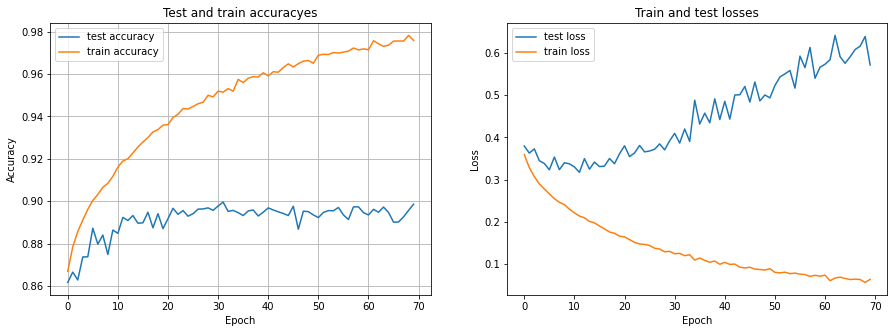

In [0]:
loss_accuracy_plot(accuracy_history_test, accuracy_history_train, loss_history_test, loss_history_train)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [0]:
from torch.functional import F
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, layer_num=2):
        super(self.__class__, self).__init__()
        self.layer_input = nn.Linear(input_shape,256)
        self.layer_hidden_one = nn.Linear(256,128)
        self.layer_hidden_two = nn.Linear(128,64)
        self.layer_hidden_three = nn.Linear(64, input_shape)
        self.layer_output = nn.Linear(input_shape, num_classes)
        
        # 60% Dropout here
        self.dropout = nn.Dropout(0.6)
        self.layer_num = layer_num
        
    def forward(self, out):       
        # Flattened the input to make sure it fits the layer input
        out = out.view(out.shape[0],-1)
        out = self.dropout(F.relu(self.layer_input(out)))
        out = self.dropout(F.relu(self.layer_hidden_one(out)))
        out = self.dropout(F.relu(self.layer_hidden_two(out)))
        out = self.dropout(F.relu(self.layer_hidden_three(out)))
        out = F.log_softmax(self.layer_output(out),dim=1)
        return out
        


In [0]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
           Dropout-6                   [-1, 64]               0
            Linear-7                  [-1, 784]          50,960
           Dropout-8                  [-1, 784]               0
            Linear-9                   [-1, 10]           7,850
Total params: 300,922
Trainable params: 300,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.15
Estimated Total Size (MB): 1.17
-------------------------------------------

In [0]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1.0e-3) 
loss_func = nn.NLLLoss() 


In [0]:
accuracy_history_test = []
accuracy_history_train = []

loss_history_test = []
loss_history_train = []
num_epoch = 70
for epoch in range(num_epoch):
  train_acc, loss_train = train()
  loss_test_accumulated = 0.0
  accuracy_accumulated = 0.0
  for _, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    test_preds = model(inputs)
    loss_test = loss_func(test_preds, targets).item()
    accuracy_accumulated += float((test_preds.argmax(dim=1) == targets).float().mean().data.cpu())
    loss_test_accumulated += float(loss_test)
    
  len_test_loader = len(test_loader)
  accuracy = accuracy_accumulated / len_test_loader
  accuracy_history_test.append(accuracy)
  accuracy_history_train.append(train_acc)
  print('Epoch:', epoch, '    acc_train:', np.round(float(train_acc), 4), '   acc_test:', np.round(accuracy, 4))
  loss_history_test.append(loss_test_accumulated / len_test_loader)
  loss_history_train.append(float(loss_train))


Epoch: 0     acc_train: 0.5274    acc_test: 0.6727
Epoch: 1     acc_train: 0.7098    acc_test: 0.7427
Epoch: 2     acc_train: 0.7523    acc_test: 0.7594
Epoch: 3     acc_train: 0.7725    acc_test: 0.7723
Epoch: 4     acc_train: 0.7827    acc_test: 0.7754
Epoch: 5     acc_train: 0.7896    acc_test: 0.7828
Epoch: 6     acc_train: 0.7962    acc_test: 0.7979
Epoch: 7     acc_train: 0.8029    acc_test: 0.7985
Epoch: 8     acc_train: 0.807    acc_test: 0.8027
Epoch: 9     acc_train: 0.812    acc_test: 0.7983
Epoch: 10     acc_train: 0.8148    acc_test: 0.8024
Epoch: 11     acc_train: 0.8171    acc_test: 0.8052
Epoch: 12     acc_train: 0.8174    acc_test: 0.7987
Epoch: 13     acc_train: 0.8233    acc_test: 0.8096
Epoch: 14     acc_train: 0.8241    acc_test: 0.8073
Epoch: 15     acc_train: 0.8241    acc_test: 0.8074
Epoch: 16     acc_train: 0.8266    acc_test: 0.8068
Epoch: 17     acc_train: 0.8279    acc_test: 0.8066
Epoch: 18     acc_train: 0.828    acc_test: 0.8097
Epoch: 19     acc_train: 

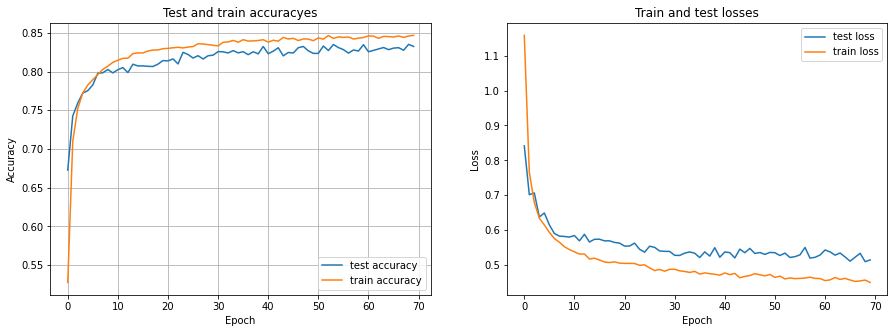

In [0]:
loss_accuracy_plot(accuracy_history_test, accuracy_history_train, loss_history_test, loss_history_train)

### Conclusions:

В первом пункте мы собрали простую сетку, которая дала нам test accuracy, достигающую 0.885.  
Во втором пункте мы собрали сетку, для которой произошел overfit, причем по графикам loss и accuracy мы видели, что в какой-то момент сетка вышла на плато, а loss начал расти.
В третьем пункте мы добавили droptout для того, чтобы избежать overfit. И это дало успешные результаты, поскольку,как видно из графика, loss начал уменьшаться и склонности к переобучению в данном случае нет